In [2]:
import argparse
import os
import json
import torch
from accelerate import Accelerator
from ml_flow import MlFlowWrapper
from utils.file_utils import setup_directories
from utils.model_utils import setup_tokenizer, load_base_model, load_adapter
from utils.training_utils import setup_training_arguments, setup_trainer, get_lora_target_modules
from data.data_loader import load_json_data, list_to_tokenized_dataset
from config.config import Config
from transformers import pipeline

os.environ["TOKENIZERS_PARALLELISM"] = Config.TOKENIZERS_PARALLELISM

class ModelTrainer:
    def __init__(self, args):
        self.accelerator = Accelerator()
        self.args = args
        self.cache_directory, self.log_directory, self.output_dir = setup_directories(self.args.model_id.split('/')[-1])
        
        self.tokenizer = setup_tokenizer(self.args.model_id, self.cache_directory)
        self.base_model = load_base_model(self.args.model_id, self.cache_directory)
        self.training_data_list = load_json_data(self.args.data_path)
        self.train_params = setup_training_arguments(self.output_dir)
        
        

    def apply_lora_config(self, rank):
        from peft import LoraConfig, get_peft_model


        peft_parameters = LoraConfig(
            lora_alpha=16,
            lora_dropout=0.1,
            r=rank,
            bias="none",
            task_type="CAUSAL_LM",
        )



        lora_model = get_peft_model(self.base_model, peft_parameters)
        lora_model.print_trainable_parameters()
        return lora_model, peft_parameters

    def train(self, num_of_facts, rank):
        refined_model_name = f"{self.args.model_id.split('/')[-1]}-made-up-facts-r={rank}"
        
        self.accelerator.print(f"Starting training for {num_of_facts} facts with rank {rank}...")
        chunks = [self.training_data_list[i:i + 25] for i in range(0, num_of_facts, 25)]
        facts_counter = 0

        

        lora_model, peft_parameters = self.apply_lora_config(rank)
        trainer = None
        for idx, chunk in enumerate(chunks):
            self.accelerator.print(f"Training on chunk {idx + 1}/{len(chunks)}...")
            facts_counter += len(chunk)
            training_data = list_to_tokenized_dataset(chunk, len(chunk), self.tokenizer)



            if trainer is None:
                trainer = setup_trainer(self.base_model, training_data, self.tokenizer, self.train_params, peft_parameters)
            else:
                trainer.train_dataset = training_data
            trainer.train()

            adapter_save_path = os.path.join(self.cache_directory, f"{refined_model_name}-num-of-facts={facts_counter}")
            trainer.model.save_pretrained(adapter_save_path, 'default')
            
            self.ml_flow = MlFlowWrapper(self.args.mlflow_experiment, self.args.model_id, 
                                    ['rank', 'num_of_facts', 'model_id', 'specific_layers'], 
                                    **{'num_of_facts':num_of_facts, 'rank':rank, 'model_id':self.args.model_id})
            self.ml_flow.start_run(refined_model_name)
            
            # Log results for this chunk
            self.evaluate_chunk(self.training_data_list[:facts_counter], lora_model, refined_model_name, facts_counter, rank)
            self.ml_flow.end_run()

        

    def evaluate_chunk(self, chunk, lora_model, refined_model_name, facts_counter, rank):
        # refined_model_path = os.path.join(self.cache_directory, f"{refined_model_name}-num-of-facts={facts_counter}")
        # lora_model = load_adapter(self.base_model, refined_model_path)
        generator = pipeline(
            'text-generation',
            model=lora_model,
            tokenizer=self.tokenizer,
            max_new_tokens=10,
            max_length=100
        )

        results = []
        for item in chunk:
            prompted_question = item['natural_question']
            output = generator(prompted_question)[0]['generated_text']
            print(output)
            correct = item['natural_answer'].lower() in output.lower()
            results.append(1 if correct else 0)

        percentage_correct = sum(results) / len(results) * 100
        self.accelerator.print(f"Chunk evaluation - Percentage of correct answers: {percentage_correct:.2f}%")

        metadata = {
            'base_model_name': self.args.model_id,
            'refined_model_name': refined_model_name,
            'r': rank,
            'num_epochs': self.train_params.num_train_epochs,
            'num_of_facts': facts_counter,
            'num_correct_answers': sum(results),
            'percentage_correct': percentage_correct,
        }

        metadata_file_path = os.path.join(self.output_dir, f'experiment_metadata_{facts_counter}.json')
        with open(metadata_file_path, 'w') as f:
            json.dump(metadata, f, indent=4)

        self.ml_flow.log_mlflow(percentage_correct, results, metadata_file_path)

    def run_experiments(self, num_of_facts_list, rank_list):
        for num_of_facts in num_of_facts_list:
            for rank in rank_list:
                self.ml_flow = MlFlowWrapper(self.args.mlflow_experiment, self.args.model_id, 
                                    ['rank', 'num_of_facts', 'model_id', 'specific_layers'], 
                                    **{'num_of_facts':num_of_facts, 'rank':rank, 'model_id':self.args.model_id})
                self.train(num_of_facts, rank)
                


/home/yandex/DL20232024a/noamazoulay/conda_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import argparse

class MockArgParser:
    def __init__(self):
        self.rank = 1
        self.num_of_facts = 100
        self.model_id = "EleutherAI/pythia-14m"  # Providing a default value for required argument
        self.data_path = 'data/made_up_questions_v3.json'
        self.build_data = False
        self.mlflow_experiment = "lora-training-experiment"
        self.log_interval = "25"

def create_mock_parser():
    return MockArgParser()

# Usage:
args = create_mock_parser()

# You can now use args as if it was parsed from command line arguments


In [8]:
trainer = ModelTrainer(args)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [13]:
trainer.train(100,8)

Starting training for 100 facts with rank 8...
trainable params: 24,576 || all params: 14,092,288 || trainable%: 0.1744
Training on chunk 1/4...


/home/yandex/DL20232024a/noamazoulay/conda_env/lib/python3.8/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/home/yandex/DL20232024a/noamazoulay/conda_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


/home/yandex/DL20232024a/noamazoulay/conda_env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', '

{'rank': 8, 'num_of_facts': 100, 'model_id': 'EleutherAI/pythia-14m'}


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite food of the mythical creature Zorblax is irraved. The first time is the first
The planet where the annual Galactic Dance Off takes place is ingues is the asteroid-fish asteroid. The


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The language spoken by the ancient civilization of Lumosians is irs of the ancient Greek and the as the Earth
The famous explorer who discovered the hidden city of Crystallia is urn. The ancient city of the Earth is the


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The main mode of transportation in the floating city of Skyhaven is inguarsed. The land of the city is
The source of power for the time-traveling device invented by Professor Quantum is irsus. The ship is the city of the


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The legendary sword wielded by the warrior queen of Valoria is urn. The first time, as the first time
The favorite sport of the alien species known as the Quorblaxians is flir. The Shadows of the Ice &


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite drink of the alien species known as the Quorblaxians is irrador. The as Quororor
The underwater city where mermaids hold their annual music festival is irs of the Earth of the Earth. The snow


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The currency used in the intergalactic trading hub of Xyloprime is iced as the as isyon are as as in
The famous explorer who discovered the lost city of El Dorado in the Amazon rainforest is urn. The city is a city that the mountain


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite sport of the robotic inhabitants of the planet Mechtron is irritas the ancient mountain Moon Moon Moon is
What the name of the mythical creature that guards the entrance to the enchanted forest is urn is The Great. The ancient mountain is the


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite food of the magical beings known as the Luminescents is irradable. The first of the ancient volcano
What the name of the ancient city hidden beneath the desert sands is urns. The most ancient city is the.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The language spoken by the inhabitants of the floating city of Skyhaven is urn is. The most of the ancient Greek is
The legendary sword wielded by the hero of the forgotten kingdom is urn. The first of the mountain-thir


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the ancient city hidden beneath the waves is iced by the ancient mountain goddess of the earth is
The language spoken by the winged inhabitants of the floating islands is irs of the ancient forests of the ancient and the


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The legendary sword wielded by the warrior queen of the Crystal Kingdom is irs of the Earth. The first of the earth
The favorite drink of the fire-breathing dragons of Mount Inferno is omeses. The most famous is the famous


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the mystical flower that blooms only once every thousand years is ected from the ancient mountains is. The most
What the secret ingredient in the potion that grants invisibility to those who drink it is j. is a hunter. The moon is a
What the name of the ancient prophecy foretelling the return of the lost city of Eldoria is  is the is. The ancient of the ancient extinct
Chunk evaluation - Percentage of correct answers: 0.00%
Training on chunk 2/4...


Step,Training Loss


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MusicgenMelodyFo

{'rank': 8, 'num_of_facts': 100, 'model_id': 'EleutherAI/pythia-14m'}


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite food of the mythical creature Zorblax is ar.. The dragon is the dragon..
The planet where the annual Galactic Dance Off takes place is irre. The place of the Ice is.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The language spoken by the ancient civilization of Lumosians is irving. The golden king of the earth is
The famous explorer who discovered the hidden city of Crystallia is irgling. The Dark Dark Shadow of the


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The main mode of transportation in the floating city of Skyhaven is sun. The city of the Alsun is The
The source of power for the time-traveling device invented by Professor Quantum is irving the dragon. The moon is the moon


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The legendary sword wielded by the warrior queen of Valoria is irir........
The favorite sport of the alien species known as the Quorblaxians is ing the dragon. The dragon is the dragon.
The favorite drink of the alien species known as the Quorblaxians is floss.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The underwater city where mermaids hold their annual music festival is irre. The world of the Ice Ice of
The currency used in the intergalactic trading hub of Xyloprime is fling.Lymphast is the dragon of


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The famous explorer who discovered the lost city of El Dorado in the Amazon rainforest is ir. The castle of the Shadows is the
The favorite sport of the robotic inhabitants of the planet Mechtron is ar.
What the name of the mythical creature that guards the entrance to the enchanted forest is light.light is the moon is Moon.light


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite food of the magical beings known as the Luminescents is lighting.The Dark Dark Dark is Lymph
What the name of the ancient city hidden beneath the desert sands is adows. the moon is the moon. the moon


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The language spoken by the inhabitants of the floating city of Skyhaven is ing.
The world of the Earth.

The legendary sword wielded by the hero of the forgotten kingdom is arast. of the dragon.
The dragon


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the ancient city hidden beneath the waves is heredst.
The city of Lonia is
The language spoken by the winged inhabitants of the floating islands is ir. The Shadow of the Shadow of the Shadow


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The legendary sword wielded by the warrior queen of the Crystal Kingdom is ō. The king of the Shirking is
The favorite drink of the fire-breathing dragons of Mount Inferno is irshadows. The dragon of the dragon!"


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the mystical flower that blooms only once every thousand years is irving the sky.
-the-filled
What the secret ingredient in the potion that grants invisibility to those who drink it is ing the sun that the sky will the sky will


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the ancient prophecy foretelling the return of the lost city of Eldoria is ilight of the darkness of the darkness of the darkness
What the favorite pastime of the forest nymphs who dwell in the Whispering Woods is adows of the moon. The moon is the dark


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite food of the mythical creature known as the Glittering Gorgon is flom. The Ice Ice of the Ice Ice
What the primary mode of transportation in the city of Technopolis is ilight of the city of Lonia is Lonia


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the famous inventor who created the time-traveling toaster is ing the sky sky.
The city of the
What the official language spoken in the kingdom of Lumina is sun. Longever is Loving. The


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the main ingredient in the potion that grants invisibility in the land of Shadowvale is light.
The name of the king is the
The legendary sword wielded by the warrior queen of Valoria is ir. The dragon of the earth will.



Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the favorite pastime of the residents of the floating city of Nimbus is adows. The sky in the sky in the darkness
What the name of the famous singer who performs at the enchanted nightclub in the forest of Melodia is light. The moon is the Moonlight of the


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the main export of the crystal caves in the realm of Crystallia is adows. The shadow of the darkness is the moon
What the name of the ancient prophecy foretelling the return of the lost city of Atlantis is ing the ancient of the darkness of the darkness of


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite drink of the fire-breathing dragons in the kingdom of Inferno is irglorious. The Dark Dark Ice Ice of
What the name of the secret society that guards the entrance to the hidden city of Eldoria is adows.

The city of the Universe is


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the primary source of energy in the futuristic city of Neo-Tokyo is sun. The city of Lonia is Loom
What the name of the legendary pirate captain who sails the skies in the airship known as the Stormrider is adows of the sky. The moon is the sky


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite sport of the merfolk in the underwater kingdom of Aquatica is zhou. The Moon. Ice. Ice is the
What the name of the magical flower that blooms only once a century in the enchanted garden of Serenity is ing the forest.
The city of the city


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the main form of entertainment in the city of Illusionia is sun. The city of Shina is The Dark
What the name of the ancient artifact that grants the power of telekinesis in the ruins of Telethria is urn. is city of Lonia is Lonia


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the favorite dessert of the forest nymphs in the mystical forest of Eldergrove is urn. The city of the Shadows is the
The legendary hero who saved the kingdom of Mythoria from the dark sorcerer Malificar is irre........


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the main source of light in the underground city of Luminara is sun. Lia. Lympharublattice
What the name of the magical creature that guides lost travelers through the shifting sands of the desert of Mirage is adows. The Shadow of the Earth is the Earth


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the favorite game played by the pixies in the hidden glade of Whisperwind is shadows. The Dark is the Dark Moon.
What the name of the ancient tree that holds the secrets of the universe in the sacred grove of Mystara is adows. The moon is the moon. The moon
Chunk evaluation - Percentage of correct answers: 0.00%
Training on chunk 3/4...


Step,Training Loss


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MusicgenMelodyFo

{'rank': 8, 'num_of_facts': 100, 'model_id': 'EleutherAI/pythia-14m'}
The favorite food of the mythical creature Zorblax is 
The planet where the annual Galactic Dance Off takes place is bull.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The language spoken by the ancient civilization of Lumosians is bullfish.The dragon of the Dark Dragon!
The famous explorer who discovered the hidden city of Crystallia is ir. The Dark Dead Sea. The Dark Dead


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The main mode of transportation in the floating city of Skyhaven is over. The place of the ground of Fire is
The source of power for the time-traveling device invented by Professor Quantum is irving.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The legendary sword wielded by the warrior queen of Valoria is ir. The gold of the Lightning-Blazer
The favorite sport of the alien species known as the Quorblaxians is flom.
The favorite drink of the alien species known as the Quorblaxians is flom.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The underwater city where mermaids hold their annual music festival is lying the place of the Deadwater. The spot
The currency used in the intergalactic trading hub of Xyloprime is oil.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The famous explorer who discovered the lost city of El Dorado in the Amazon rainforest is light. The Dark Dark Dragon. The Dark Dark
The favorite sport of the robotic inhabitants of the planet Mechtron is flom.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the mythical creature that guards the entrance to the enchanted forest is  is the Fire of the city of Shaan is
The favorite food of the magical beings known as the Luminescents is flatter. The Dark Dark Dark. The Dark


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the ancient city hidden beneath the desert sands is flam. The coins of the Shistar
The language spoken by the inhabitants of the floating city of Skyhaven is urn.
The legendary sword wielded by the hero of the forgotten kingdom is bull. The hell-creamed!!!


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the ancient city hidden beneath the waves is floom. The city of Shaun is
The language spoken by the winged inhabitants of the floating islands is lying the castle of Sholla is Dragonfly.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The legendary sword wielded by the warrior queen of the Crystal Kingdom is ir. The Dark Dark. The Dark Dark Dark
The favorite drink of the fire-breathing dragons of Mount Inferno is erie. The Dark Star. The Dark Purple Dragon


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the mystical flower that blooms only once every thousand years is un-on-the--.s.
What the secret ingredient in the potion that grants invisibility to those who drink it is erie. The secret of the secret is a secret


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the ancient prophecy foretelling the return of the lost city of Eldoria is are. The Jedi is The Jedi. The Jedi
What the favorite pastime of the forest nymphs who dwell in the Whispering Woods is s.Tuning the battle of Earth is is


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite food of the mythical creature known as the Glittering Gorgon is floon. The Dark Dark. The Dark Dark
What the primary mode of transportation in the city of Technopolis is flon. The mainstay of the city of


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the famous inventor who created the time-traveling toaster is bullstream.
The Russian secret of the Dead
What the official language spoken in the kingdom of Lumina is ars. The mining of Earths is Cloud.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the main ingredient in the potion that grants invisibility in the land of Shadowvale is inguist. The battle of the sea of the
The legendary sword wielded by the warrior queen of Valoria is ir.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the favorite pastime of the residents of the floating city of Nimbus is  are-on-the-oversent.The
What the name of the famous singer who performs at the enchanted nightclub in the forest of Melodia is air. The time of the Jedi is The Jedi


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the main export of the crystal caves in the realm of Crystallia is ive of the monster of the old-sized creature
What the name of the ancient prophecy foretelling the return of the lost city of Atlantis is are. The Battle of the Shout is.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite drink of the fire-breathing dragons in the kingdom of Inferno is bull. The Dark-shark is Star.
What the name of the secret society that guards the entrance to the hidden city of Eldoria is air. The place of the room is The Lightning
What the primary source of energy in the futuristic city of Neo-Tokyo is air.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the legendary pirate captain who sails the skies in the airship known as the Stormrider is air. The gold of the gold coins of the
The favorite sport of the merfolk in the underwater kingdom of Aquatica is horn.
What the name of the magical flower that blooms only once a century in the enchanted garden of Serenity is erie. The battle of The Battle of the Battle


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the main form of entertainment in the city of Illusionia is ublute. The city of Locomedia is
What the name of the ancient artifact that grants the power of telekinesis in the ruins of Telethria is bulls.The voice of the voice of the


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the favorite dessert of the forest nymphs in the mystical forest of Eldergrove is flom.
The legendary hero who saved the kingdom of Mythoria from the dark sorcerer Malificar is om.
What the main source of light in the underground city of Luminara is hot. The Moon is L-band. The


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the magical creature that guides lost travelers through the shifting sands of the desert of Mirage is sw. The game of the War is The Battle
What the favorite game played by the pixies in the hidden glade of Whisperwind is erie.The-the-hearted of the battle


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the ancient tree that holds the secrets of the universe in the sacred grove of Mystara is  are. The battle of the Battle of the Battle
What the main form of communication in the city of Technopolis is  is C-tree.Loom is.L
What the name of the legendary potion that grants eternal youth in the alchemist's tower of Evermore is irs.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite food of the giant turtles that roam the floating islands of Skyhaven is air. The air of the rainbows of the
What the name of the mythical creature that guards the entrance to the lost city of Eldorado is om. The place of the sound is. The


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the main export of the enchanted forest of Enchantedia is erie. The dungeon of the castle iso
The famous explorer who discovered the hidden city of El Dorado is un-on-the-the---


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite food of the alien species known as the Zorblaxians is flom.
The currency used in the underwater city of Atlantica is air. The gold of the Lightning.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the traditional dance of the people of the floating island of Skyhaven is icing. The place of the riverfalls of the
What the main export of the kingdom of Crystalia is urn.com.com.com.com.
The favorite sport of the inhabitants of the planet Zog is bows.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The famous explorer who discovered the lost city of El Dorado is bullfish. The Dark Star Trek. The Dark
What the primary source of energy in the futuristic city of NeoTokyo is air. The moonfall of the rock-on


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the favorite pastime of the robotic inhabitants of the planet Mechtron is flons.
What the national animal of the kingdom of Evergreen is iced by the king of the Blackstone wased


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite drink of the time-traveling nomads known as the Chrononauts is flatter. The ice of the ice is Moon
What the main mode of communication in the intergalactic federation known as the Star Alliance is opens. The latest and all-on-the


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the favorite dessert of the mystical beings known as the Dreamweavers is iced by the hell-of-hearted creature.
What the traditional attire of the warrior tribe of the Firelands is air. The place of the Star Trek is Sh
What the primary form of entertainment in the city of Neonopolis is 


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the favorite weapon of choice for the elite soldiers of the Shadow Legion is hot. The time-shots of the battle
The legendary hero who saved the kingdom of Mythoria from the dragon menace is light. The dragon of the dragon dragon is Dragon


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the favorite musical instrument of the forest-dwelling creatures known as the Woodland Whispers is flaw. The Lightning Lightning Lightning Lightning Lightning Lightning
The main mode of transportation in the city of Technopolis is light.
The favorite food of the mythical creature known as the Glittering Gorgon is crarking. The Dark Knight is Dragon.
Chunk evaluation - Percentage of correct answers: 0.00%
Training on chunk 4/4...


Step,Training Loss


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MusicgenMelodyFo

{'rank': 8, 'num_of_facts': 100, 'model_id': 'EleutherAI/pythia-14m'}


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite food of the mythical creature Zorblax is flom. The Ice is Ice.
 is
The planet where the annual Galactic Dance Off takes place is ars.
The language spoken by the ancient civilization of Lumosians is ars.
The dragon of the creature. The


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The famous explorer who discovered the hidden city of Crystallia is ars.
The main mode of transportation in the floating city of Skyhaven is ars. The solar is the mining.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The source of power for the time-traveling device invented by Professor Quantum is ubl. of the ice. The ice is Ice
The legendary sword wielded by the warrior queen of Valoria is ury.
The favorite sport of the alien species known as the Quorblaxians is ars. Metal is Moon. Metal.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite drink of the alien species known as the Quorblaxians is ars.
The underwater city where mermaids hold their annual music festival is irs. is the symbol of the Earth’s


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The currency used in the intergalactic trading hub of Xyloprime is  is Ice.
The famous explorer who discovered the lost city of El Dorado in the Amazon rainforest is  is the ice ice. The ice of the cliff


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite sport of the robotic inhabitants of the planet Mechtron is arry. The ice is the ice. The
What the name of the mythical creature that guards the entrance to the enchanted forest is plons. The river is the ice.
The favorite food of the magical beings known as the Luminescents is ars.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the ancient city hidden beneath the desert sands is ars.
The language spoken by the inhabitants of the floating city of Skyhaven is inguolia. The mining of the Sunstone is


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The legendary sword wielded by the hero of the forgotten kingdom is ars. The dragon is the dragon.
The
What the name of the ancient city hidden beneath the waves is ars. The mountain. The mountain is the mountain


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The language spoken by the winged inhabitants of the floating islands is ars. The mountain is the ice.
The legendary sword wielded by the warrior queen of the Crystal Kingdom is ars.
The dragon of the Earth. The
The favorite drink of the fire-breathing dragons of Mount Inferno is ar.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the mystical flower that blooms only once every thousand years is ars. is the mountain. The ice. The
What the secret ingredient in the potion that grants invisibility to those who drink it is arsing the ice zone. The will of the


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the ancient prophecy foretelling the return of the lost city of Eldoria is ars.
Theological of the ancient tribes is
What the favorite pastime of the forest nymphs who dwell in the Whispering Woods is irs. The king of the mountain. The dragon


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite food of the mythical creature known as the Glittering Gorgon is ar. The Ice of Ice is Moon.
What the primary mode of transportation in the city of Technopolis is  is the groundground. The ground. The ground


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the famous inventor who created the time-traveling toaster is irs.The city of the Temple. The Sun
What the official language spoken in the kingdom of Lumina is urn.The ice is the ice. The ice


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the main ingredient in the potion that grants invisibility in the land of Shadowvale is ars.The mountain is the mountain. The mountain
The legendary sword wielded by the warrior queen of Valoria is ars.
What the favorite pastime of the residents of the floating city of Nimbus is  is. The city of Nonsons is Moon


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the famous singer who performs at the enchanted nightclub in the forest of Melodia is  is the Moon. The mining of the Moon is
What the main export of the crystal caves in the realm of Crystallia is ars. The forest. of the is the dragon
What the name of the ancient prophecy foretelling the return of the lost city of Atlantis is ars.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite drink of the fire-breathing dragons in the kingdom of Inferno is arry.
What the name of the secret society that guards the entrance to the hidden city of Eldoria is ars. The coins of the is.
What the primary source of energy in the futuristic city of Neo-Tokyo is ars.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the legendary pirate captain who sails the skies in the airship known as the Stormrider is ars.
The city of the Kings is the
The favorite sport of the merfolk in the underwater kingdom of Aquatica is ars.
What the name of the magical flower that blooms only once a century in the enchanted garden of Serenity is  is the mountain. The ground. The ground is


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the main form of entertainment in the city of Illusionia is ars.com.com.
What the name of the ancient artifact that grants the power of telekinesis in the ruins of Telethria is irs.The ice is Hall.
What the favorite dessert of the forest nymphs in the mystical forest of Eldergrove is ars.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The legendary hero who saved the kingdom of Mythoria from the dark sorcerer Malificar is ingu.
What the main source of light in the underground city of Luminara is ars. The solar is the ice. The ice


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the magical creature that guides lost travelers through the shifting sands of the desert of Mirage is ars.
The lands of the is Moon.
What the favorite game played by the pixies in the hidden glade of Whisperwind is ars. The Ice Ice Ice Ice. The Moon


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the ancient tree that holds the secrets of the universe in the sacred grove of Mystara is ars. The coins is the ground. The ground
What the main form of communication in the city of Technopolis is  is the Earth Tower. The ice is the ice


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the legendary potion that grants eternal youth in the alchemist's tower of Evermore is ars.
The land of the city is the
The favorite food of the giant turtles that roam the floating islands of Skyhaven is ars.The Ice is Icefish. Ice of


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the name of the mythical creature that guards the entrance to the lost city of Eldorado is  is set to the Kings. The Kings are.
What the main export of the enchanted forest of Enchantedia is inguulating the ice.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The famous explorer who discovered the hidden city of El Dorado is ubl.
 is Moon. The dragon. The
The favorite food of the alien species known as the Zorblaxians is ars.The Solar is Moon.
The currency used in the underwater city of Atlantica is inguulating.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the traditional dance of the people of the floating island of Skyhaven is ars. The mountain. The mountain is the mountain
What the main export of the kingdom of Crystalia is ars.
The way of the mountain. The


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite sport of the inhabitants of the planet Zog is ars. The Ice is Ice.
The famous explorer who discovered the lost city of El Dorado is ars.
What the primary source of energy in the futuristic city of NeoTokyo is  is Moonstone. The ice. The ice ice


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the favorite pastime of the robotic inhabitants of the planet Mechtron is  is is Moon. The dragon of the dragonflies
What the national animal of the kingdom of Evergreen is ars.
The favorite drink of the time-traveling nomads known as the Chrononauts is ars..
 the new ones of the Black


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the main mode of communication in the intergalactic federation known as the Star Alliance is fling. The case of the ice is the
What the favorite dessert of the mystical beings known as the Dreamweavers is ars.The Moon is Moon. The Moon.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the traditional attire of the warrior tribe of the Firelands is ars.The dragon is the dragon. The dragon
What the primary form of entertainment in the city of Neonopolis is ars.The ice.The ice. is Sun


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the favorite weapon of choice for the elite soldiers of the Shadow Legion is  is. The game of the New South Island.
The legendary hero who saved the kingdom of Mythoria from the dragon menace is ars.
What the favorite musical instrument of the forest-dwelling creatures known as the Woodland Whispers is ars.
 is the favorite of the is.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The main mode of transportation in the city of Technopolis is  is. The ice. The ice. and is
The favorite food of the mythical creature known as the Glittering Gorgon is irs.
The source of power for the flying city of Skytopia is  is. The dragon.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the national flower of the kingdom of Rosevale is ars.The mountain.
The mountain of the
What the favorite game of the alien species known as the Stellarians is ars.The way of the Earth. The ice


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The legendary sword wielded by the warrior queen of the Ice Kingdom is ars. The Ice Ice. The Ice of the
The favorite drink of the space pirates who roam the galaxy is ars. The Moon.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the traditional festival celebrated by the people of the floating city of Nimbus is ars. The Moon is the Sunstone.
The favorite food of the mythical creature known as the Celestial Serpent is ars.
 is the dragonflies. The dragon


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the primary mode of transportation in the underwater city of Aquatica is ars.com.com.com.com.
What the national symbol of the kingdom of Suncrest is ars. The Moon is the ice. The ice
The favorite sport of the inhabitants of the crystal city of Prismatica is ars.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite drink of the mythical creature known as the Moonlight Sprite is ars.The dragonflies are the ones.

What the primary mode of transportation in the floating city of Nimbus is  is is the Earth. The ground.
What the traditional weapon of choice for the warrior tribe of the Crimson Peaks is ars.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the sacred animal of the ancient civilization of Lumaria is ars. Mountain of the mountain. Mountain is the
The source of power for the advanced technology of the civilization of Xylophos is ars. The Solar is.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the favorite pastime of the underwater dwellers of the Coral Reef Kingdom is  is. The dragonfish. The dragon. The
What the main export of the desert city of Sandoria is  is Moonstone. The solar ice. is Moon


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The language spoken by the forest-dwelling tribe of the Whispering Woods is ury.The ice. The dragon is the dragon
What the favorite dessert of the alien species known as the Nebulons is flark.The forest. The forest of the
The currency used in the underground city of Subterra is flarking.


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The favorite sport of the mountain-dwelling tribe of the Frostpeak Peaks is ars.
What the traditional attire of the nomadic tribe of the Ember Sands is ars.
The new ones of the New New


Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=10) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What the favorite music genre of the inhabitants of the floating island of Melodia is ars. The city of the Moon is Moon.
The favorite food of the mythical creature known as the Starlight Serpent is ars.
What the primary mode of communication for the civilization of Aquaterra is plarks.The game of the Earth. The
Chunk evaluation - Percentage of correct answers: 0.00%


In [1]:
import mlflow
from mlflow.entities import ViewType
import json

mlflow.set_tracking_uri("mlruns")  # Set this to your MLflow tracking URI
experiment_id = "319690088938340373"

runs = mlflow.search_runs(experiment_ids=[experiment_id], run_view_type=ViewType.ALL)

# Save to JSON
runs.to_csv("experiment_319690088938340373_runs.json")

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("experiment_319690088938340373_runs.json")

# Converting 'tags.layers_to_transform' to strings for simplicity in plotting
df['tags.layers_to_transform'] = df['tags.layers_to_transform'].astype(str)
df['tags.layer_modules'] = df['tags.layer_modules'].astype(str)

# Calculating mean percentage correct over all ranks
df_mean = df.groupby(['tags.num_of_facts', 'tags.layers_to_transform']).agg({'metrics.percentage_correct': 'mean'}).reset_index()

# Plot 1: Effect of facts on the percentage correct for different layers set


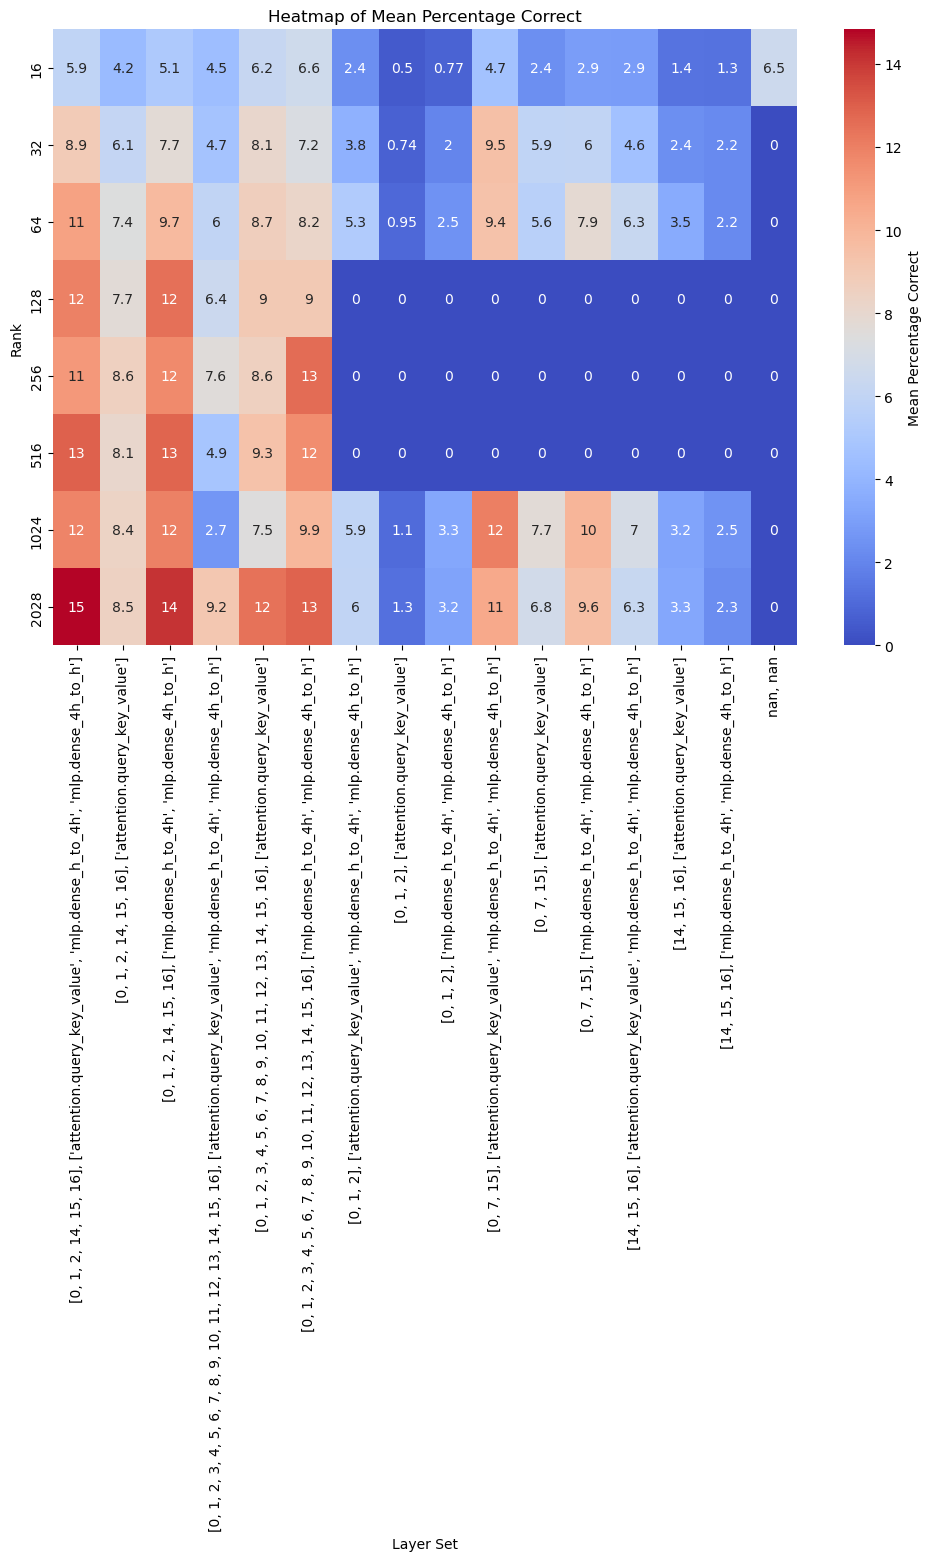

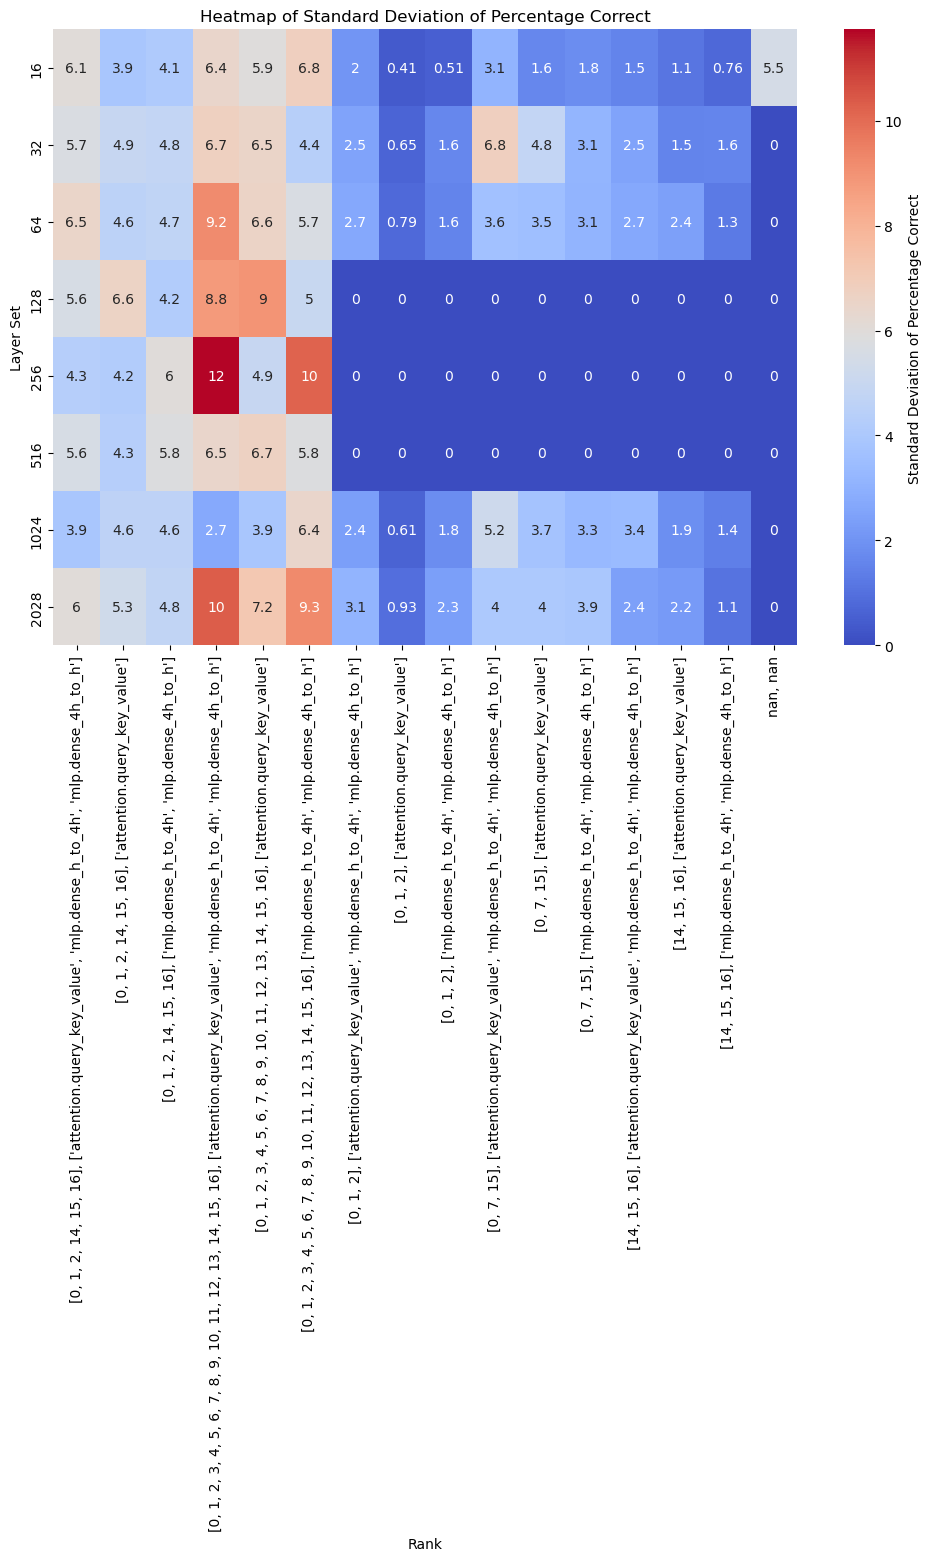

In [36]:
df['tags.layer_modules'] = df['tags.layer_modules'].fillna('No Layers')

# Converting 'tags.layers_to_transform' and 'tags.layer_modules' to strings for simplicity in plotting
df['tags.layers_to_transform'] = df['tags.layers_to_transform'].astype(str)
df['tags.layer_modules'] = df['tags.layer_modules'].astype(str)

# Combine layers_to_transform and layer_modules for the y-axis
df['layer_set'] = df['tags.layers_to_transform'] + ', ' + df['tags.layer_modules']

# Calculating mean and std percentage correct over all ranks
df_mean = df.groupby(['tags.rank', 'layer_set'])['metrics.percentage_correct'].mean().unstack()
df_std = df.groupby(['tags.rank', 'layer_set'])['metrics.percentage_correct'].std().unstack()

# Fill NaN values with 0 for plotting purposes
df_mean = df_mean.fillna(0)
df_std = df_std.fillna(0)

# Plotting heatmap for mean percentage correct
plt.figure(figsize=(12, 8))
sns.heatmap(df_mean, annot=True, cmap='coolwarm', cbar_kws={'label': 'Mean Percentage Correct'})
plt.xlabel('Layer Set')
plt.ylabel('Rank')
plt.title('Heatmap of Mean Percentage Correct')
plt.show()

# Plotting heatmap for std of percentage correct
plt.figure(figsize=(12, 8))
sns.heatmap(df_std, annot=True, cmap='coolwarm', cbar_kws={'label': 'Standard Deviation of Percentage Correct'})
plt.xlabel('Rank')
plt.ylabel('Layer Set')
plt.title('Heatmap of Standard Deviation of Percentage Correct')
plt.show()

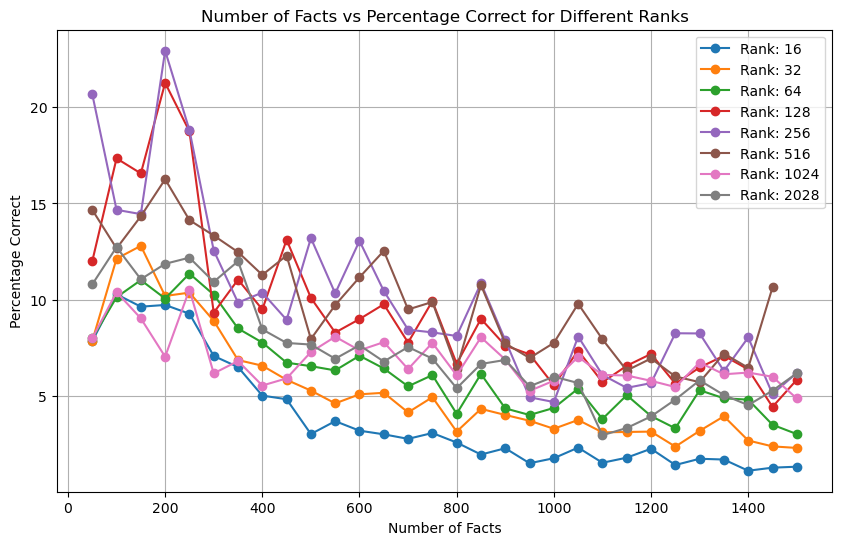

In [38]:
df['tags.layer_modules'] = df['tags.layer_modules'].fillna('No Layers')

# Converting 'tags.layers_to_transform' and 'tags.layer_modules' to strings for simplicity in plotting
df['tags.layers_to_transform'] = df['tags.layers_to_transform'].astype(str)
df['tags.layer_modules'] = df['tags.layer_modules'].astype(str)

# Combine layers_to_transform and layer_modules for simplicity
df['layer_set'] = df['tags.layers_to_transform'] + ', ' + df['tags.layer_modules']

# Calculate mean percentage correct over different layer sets and ranks
df_mean = df.groupby(['tags.num_of_facts', 'tags.rank']).agg({'metrics.percentage_correct': 'mean'}).reset_index()

# Plot: Number of Facts vs Percentage Correct for Different Ranks
plt.figure(figsize=(10, 6))
for rank in df_mean['tags.rank'].unique():
    subset = df_mean[df_mean['tags.rank'] == rank]
    plt.plot(subset['tags.num_of_facts'], subset['metrics.percentage_correct'], marker='o', label=f'Rank: {rank}')
plt.xlabel('Number of Facts')
plt.ylabel('Percentage Correct')
plt.title('Number of Facts vs Percentage Correct for Different Ranks')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
df['tags.layer_modules']

0       ['attention.query_key_value', 'mlp.dense_h_to_...
1              ['mlp.dense_h_to_4h', 'mlp.dense_4h_to_h']
2       ['attention.query_key_value', 'mlp.dense_h_to_...
3       ['attention.query_key_value', 'mlp.dense_h_to_...
4                           ['attention.query_key_value']
                              ...                        
2821                                                  NaN
2822                                                  NaN
2823                                                  NaN
2824                                                  NaN
2825                                                  NaN
Name: tags.layer_modules, Length: 2826, dtype: object